In [1]:
import os

os.environ["KERAS_BACKEND"] = "jax"  # @param ["tensorflow", "jax", "torch"]


import numpy as np
import keras
from keras import layers
from keras import ops
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import scipy.io
import shutil
import matplotlib.patches as patches


In [3]:
# Paths for images and annotations
image_folder = "./101_ObjectCategories/airplanes/"
annotation_folder = "./Annotations/Airplanes_Side_2/"

# Download the dataset
file_path = keras.utils.get_file(
    "dataset",
    "https://data.caltech.edu/records/mzrjq-6wc02/files/caltech-101.zip",
    extract=True,
    archive_format="zip",
    cache_dir="./"
)
main_folder = os.path.dirname(file_path)

# Extract files
shutil.unpack_archive(
    os.path.join(main_folder, "caltech-101", "101_ObjectCategories.tar.gz"),
    "./"
)
shutil.unpack_archive(
    os.path.join(main_folder, "caltech-101", "Annotations.tar"),
    "./"
)

# Lists for images and annotations
image_list = []
annotation_list = []

for filename in os.listdir(image_folder):
    if os.path.isfile(os.path.join(image_folder, filename)):
        image_list.append(filename)

for filename in os.listdir(annotation_folder):
    if os.path.isfile(os.path.join(annotation_folder, filename)):
        annotation_list.append(filename)

# Sort the lists
image_list.sort()
annotation_list.sort()

# Resize settings
resize_to = 224

# Store processed data
images_data = []
bbox_data = []

# Process each file
for index in range(len(annotation_list)):
    # Load annotation
    annotation = scipy.io.loadmat(os.path.join(annotation_folder, annotation_list[index]))["box_coord"][0]

    x1 = annotation[2]
    y1 = annotation[0]
    x2 = annotation[3]
    y2 = annotation[1]

    # Load and resize image
    image = keras.utils.load_img(os.path.join(image_folder, image_list[index]))
    width, height = image.size
    image = image.resize((resize_to, resize_to))

    # Add image and bounding box to lists
    images_data.append(keras.utils.img_to_array(image))
    bbox_data.append((x1 / width, y1 / height, x2 / width, y2 / height))

# Convert to arrays
images_array = np.array(images_data)
bbox_array = np.array(bbox_data)

# Train-test split
split_train = int(len(images_array) * 0.7)
split_val = int(len(images_array) * 0.9)

x_train = images_array[:split_train]
y_train = bbox_array[:split_train]

x_val = images_array[split_train:split_val]
y_val = bbox_array[split_train:split_val]

x_test = images_array[split_val:]
y_test = bbox_array[split_val:]


In [4]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=keras.activations.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

In [5]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size

    def call(self, images):
        input_shape = images.shape
        batch_size = input_shape[0]
        height = input_shape[1]
        width = input_shape[2]
        channels = input_shape[3]
        
        # Calculate the number of patches
        patches_along_height = height // self.patch_size
        patches_along_width = width // self.patch_size
        
        # Extract patches
        patches = keras.ops.image.extract_patches(images, size=self.patch_size)
        
        # Reshape patches
        reshaped_patches = patches.reshape(
            batch_size,
            patches_along_height * patches_along_width,
            self.patch_size * self.patch_size * channels
        )
        
        return reshaped_patches

    def get_config(self):
        return {"patch_size": self.patch_size}

Image size: 224 X 224
Patch size: 32 X 32
49 patches per image 
3072 elements per patch


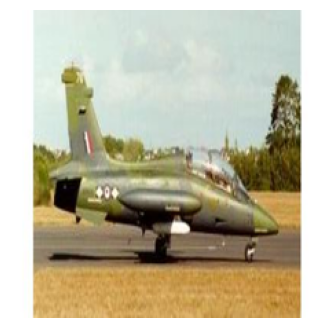

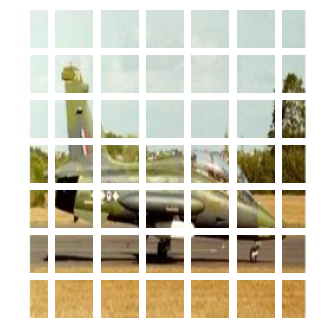

In [6]:
patch_size = 32  # Size of the patches to be extracted from the input images

plt.figure(figsize=(4, 4))
plt.imshow(x_train[0].astype("uint8"))
plt.axis("off")

patches = Patches(patch_size)(np.expand_dims(x_train[0], axis=0))
print(f"Image size: {resize_to} X {resize_to}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"{patches.shape[1]} patches per image \n{patches.shape[-1]} elements per patch")


n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = ops.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(ops.convert_to_numpy(patch_img).astype("uint8"))
    plt.axis("off")

In [7]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super().__init__()
        self.num_patches = num_patches
        self.projection = keras.layers.Dense(units=projection_dim)
        self.position_embedding = keras.layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def get_config(self):
        return {
            "num_patches": self.num_patches,
            "projection_dim": self.projection.units,
        }

    def call(self, patch):
        # Create a sequence of positions
        positions = np.arange(self.num_patches).reshape(1, -1)
        
        # Apply projection to the patches
        projected_patches = self.projection(patch)
        
        # Add position embeddings
        encoded_patches = projected_patches + self.position_embedding(positions)
        return encoded_patches

In [8]:
def create_vit_object_detector(
    input_shape,
    patch_size,
    num_patches,
    projection_dim,
    num_heads,
    transformer_units,
    transformer_layers,
    mlp_head_units,
):
    inputs = keras.Input(shape=input_shape)
    # Create patches
    patches = Patches(patch_size)(inputs)
    # Encode patches
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.3)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.3)

    bounding_box = layers.Dense(4)(
        features
    )  # Final four neurons that output bounding box

    # return Keras model.
    return keras.Model(inputs=inputs, outputs=bounding_box)


Epoch 1/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 20s 759ms/step - loss: 1.2392 - val_loss: 0.3653
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - loss: 0.3556 - val_loss: 0.3191
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.2890 - val_loss: 0.2697
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.2650 - val_loss: 0.2413
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.2009 - val_loss: 0.0526
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.1266 - val_loss: 0.0335
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.1080 - val_loss: 0.0179
Epoch 8/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0811 - val_loss: 0.0118
Epoch 9/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0602 - val_loss: 0.0041
Epoch 10/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0489 - val_loss: 0.0019
Epoch 11/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0421 - val_loss: 0.0021
Epoch 12/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/st

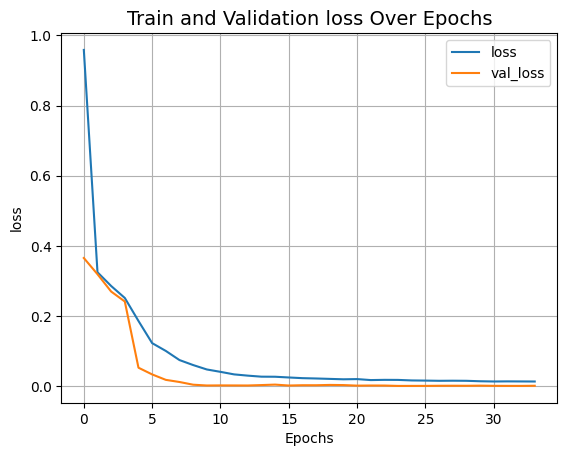

In [9]:
def run_experiment(model, learning_rate, weight_decay, batch_size, num_epochs):
    optimizer = keras.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    # Compile model.
    model.compile(optimizer=optimizer, loss=keras.losses.MeanSquaredError())

    checkpoint_filepath = "vit_object_detector.weights.h5"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_loss",
        save_best_only=True,
        save_weights_only=True,
    )

    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        #validation_split=0.1,
        validation_data=(x_val, y_val),
        callbacks=[
            checkpoint_callback,
            keras.callbacks.EarlyStopping(monitor="val_loss", patience=10),
        ],
    )

    return history


input_shape = (resize_to, resize_to, 3)  # input image shape
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 32
num_epochs = 100
num_patches = (resize_to // patch_size) ** 2
projection_dim = 64
num_heads = 4
# Size of the transformer layers
transformer_units = [
    projection_dim * 2,
    projection_dim,
]
transformer_layers = 4
mlp_head_units = [2048, 1024, 512, 64, 32]  # Size of the dense layers


history = []
num_patches = (resize_to // patch_size) ** 2

vit_object_detector = create_vit_object_detector(
    input_shape,
    patch_size,
    num_patches,
    projection_dim,
    num_heads,
    transformer_units,
    transformer_layers,
    mlp_head_units,
)

# Train model
history = run_experiment(
    vit_object_detector, learning_rate, weight_decay, batch_size, num_epochs
)


def plot_history(item):
    plt.plot(history.history[item], label=item)
    plt.plot(history.history["val_" + item], label="val_" + item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title("Train and Validation {} Over Epochs".format(item), fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()


plot_history("loss")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Average IoU for test images: 0.872470240429028


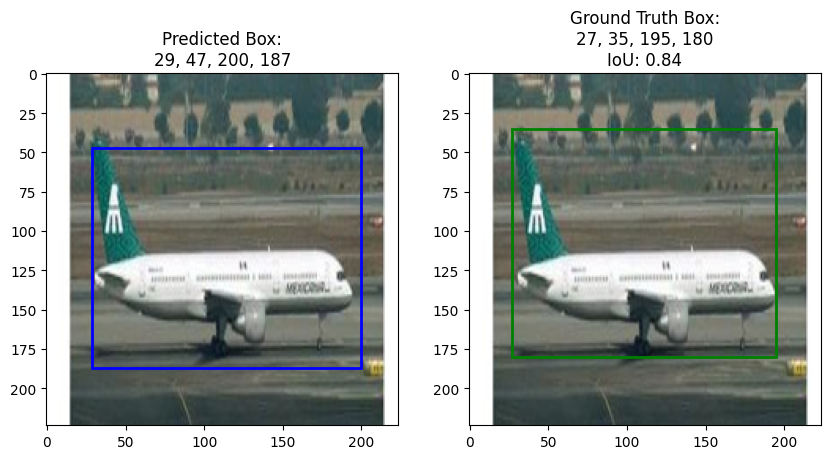

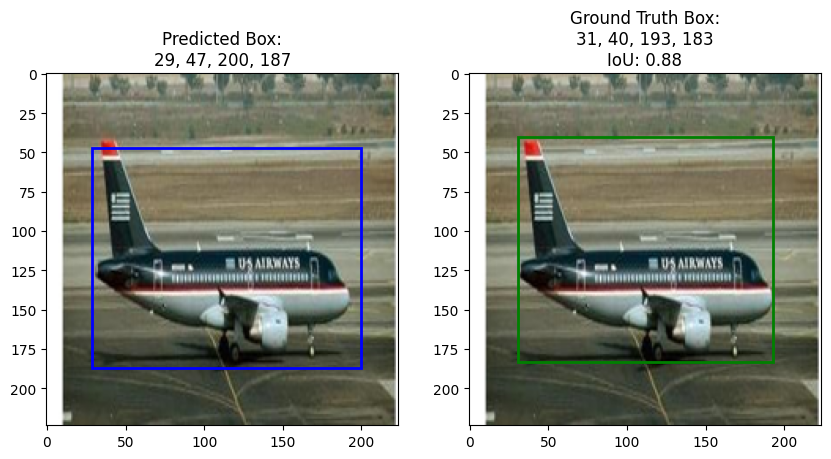

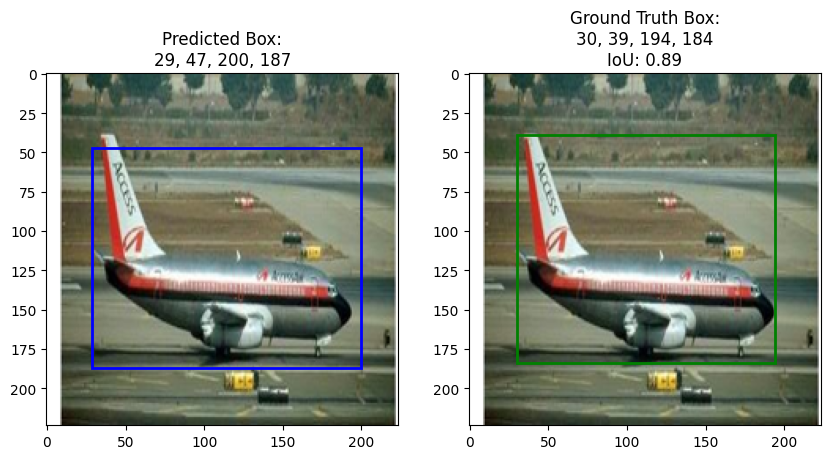

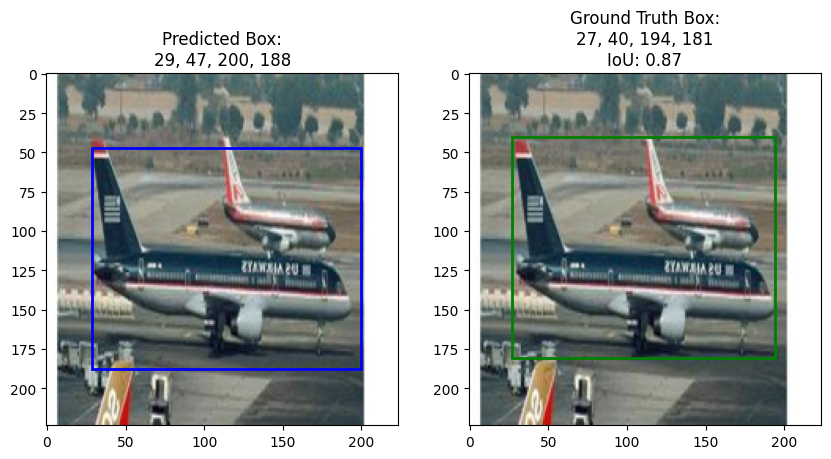

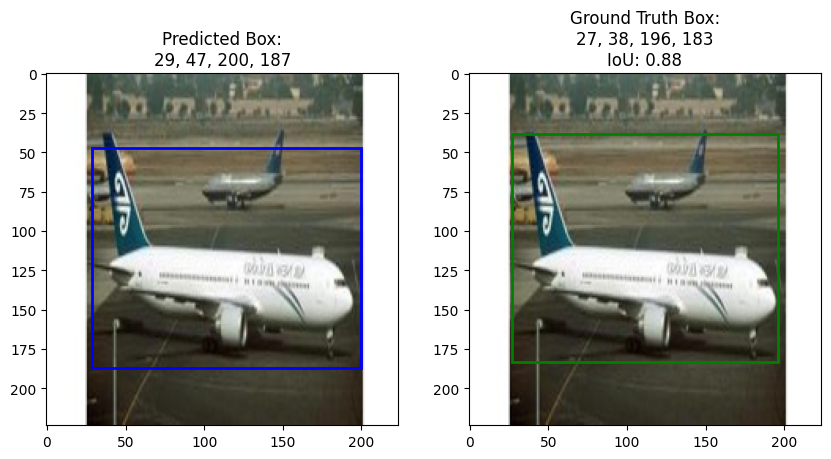

In [13]:
from matplotlib import patches

# Saves the model in current path
vit_object_detector.save("vit_object_detector.keras")

# Function to calculate IoU (Intersection Over Union) for two bounding boxes
def calculate_iou(predicted_box, true_box):
    # Find the (x, y) coordinates of the intersection rectangle
    x_top_intersection = max(predicted_box[0], true_box[0])
    y_top_intersection = max(predicted_box[1], true_box[1])
    x_bottom_intersection = min(predicted_box[2], true_box[2])
    y_bottom_intersection = min(predicted_box[3], true_box[3])

    # Calculate the area of the intersection rectangle
    intersection_area = max(0, x_bottom_intersection - x_top_intersection + 1) * max(
        0, y_bottom_intersection - y_top_intersection + 1
    )

    # Calculate the areas of the predicted and ground truth boxes
    predicted_box_area = (predicted_box[2] - predicted_box[0] + 1) * (
        predicted_box[3] - predicted_box[1] + 1
    )
    true_box_area = (true_box[2] - true_box[0] + 1) * (
        true_box[3] - true_box[1] + 1
    )

    # Calculate the IoU by dividing intersection area by the union area
    union_area = predicted_box_area + true_box_area - intersection_area
    return intersection_area / float(union_area)


# Initialize variables for evaluation
image_index = 0
average_iou = 0

# Visualize and compare predictions for a few test images
for test_image in x_test[:5]:
    fig, (axis1, axis2) = plt.subplots(1, 2, figsize=(10, 10))

    # Display the test image
    axis1.imshow(test_image.astype("uint8"))
    axis2.imshow(test_image.astype("uint8"))

    # Preprocess the test image
    resized_image = cv2.resize(
        test_image, (resize_to, resize_to), interpolation=cv2.INTER_AREA
    )
    resized_image = np.expand_dims(resized_image, axis=0)

    # Get predictions from the model
    predictions = vit_object_detector.predict(resized_image)[0]
    height, width = test_image.shape[0:2]

    # Predicted bounding box
    x1_pred = int(predictions[0] * width)
    y1_pred = int(predictions[1] * height)
    x2_pred = int(predictions[2] * width)
    y2_pred = int(predictions[3] * height)
    predicted_box = [x1_pred, y1_pred, x2_pred, y2_pred]

    # Draw predicted bounding box
    pred_rect = patches.Rectangle(
        (x1_pred, y1_pred),
        x2_pred - x1_pred,
        y2_pred - y1_pred,
        linewidth=2,
        edgecolor="blue",
        facecolor="none",
    )
    axis1.add_patch(pred_rect)
    axis1.set_title(
        "Predicted Box:\n"
        + f"{x1_pred}, {y1_pred}, {x2_pred}, {y2_pred}"
    )

    # Ground truth bounding box
    x1_true = int(y_test[image_index][0] * width)
    y1_true = int(y_test[image_index][1] * height)
    x2_true = int(y_test[image_index][2] * width)
    y2_true = int(y_test[image_index][3] * height)
    true_box = [x1_true, y1_true, x2_true, y2_true]

    # Draw ground truth bounding box
    truth_rect = patches.Rectangle(
        (x1_true, y1_true),
        x2_true - x1_true,
        y2_true - y1_true,
        linewidth=2,
        edgecolor="green",
        facecolor="none",
    )
    axis2.add_patch(truth_rect)
    axis2.set_title(
        "Ground Truth Box:\n"
        + f"{x1_true}, {y1_true}, {x2_true}, {y2_true}\n"
        + "IoU: "
        + str(round(calculate_iou(predicted_box, true_box), 2))
    )

    # Update IoU calculations
    average_iou += calculate_iou(predicted_box, true_box)
    image_index += 1

# Display the average IoU
print("Average IoU for test images:", average_iou / 5)

# Show all plots
plt.show()


In [14]:
# Initialize variables for evaluation
image_index = 0
average_iou = 0

# Visualize and compare predictions for a few test images
for test_image in x_test:
    # Preprocess the test image
    resized_image = cv2.resize(
        test_image, (resize_to, resize_to), interpolation=cv2.INTER_AREA
    )
    resized_image = np.expand_dims(resized_image, axis=0)

    # Get predictions from the model
    predictions = vit_object_detector.predict(resized_image)[0]
    height, width = test_image.shape[0:2]

    # Predicted bounding box
    x1_pred = int(predictions[0] * width)
    y1_pred = int(predictions[1] * height)
    x2_pred = int(predictions[2] * width)
    y2_pred = int(predictions[3] * height)
    predicted_box = [x1_pred, y1_pred, x2_pred, y2_pred]

    # Ground truth bounding box
    x1_true = int(y_test[image_index][0] * width)
    y1_true = int(y_test[image_index][1] * height)
    x2_true = int(y_test[image_index][2] * width)
    y2_true = int(y_test[image_index][3] * height)
    true_box = [x1_true, y1_true, x2_true, y2_true]
    
    # Update IoU calculations
    average_iou += calculate_iou(predicted_box, true_box)
    image_index += 1

# Display the average IoU
print("\n \033[94m \033[1m Average IoU for test images:", average_iou / len(x_test))



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1